In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 101.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import re
import pandas as pd
from datetime import datetime

#############################
# 1. Read and Process the CSV
#############################

# Update this path to where your CSV file is stored.
csv_path = r"/content/drive/My Drive/final (2).csv"
# For example: r"C:\Users\YourName\Documents\final.csv"

# Read the CSV and parse the datetime column.
df = pd.read_csv(csv_path, parse_dates=['datetime'])
print("CSV columns:", df.columns)

# Create a new column 'date' that contains just the date part
df['date'] = df['datetime'].dt.date

#####################################
# 2. List and Process TIFF Files
#####################################

# Update this to the folder path where your TIFF files are stored.
tiff_folder = r"/content/drive/My Drive/YourDriveFolder"
# For example: r"C:\Users\YourName\Google Drive\YourDriveFolder"

# Define a regex pattern to extract the date from the TIFF filenames.
# Expected pattern: 'NYC_16day_YYYY_YYYY-MM-DD.tif'
pattern = re.compile(r'NYC_16day_\d{4}_(\d{4}-\d{2}-\d{2})\.tif')

# Prepare a list to collect match records.
matching_records = []

# Loop over files in the TIFF folder.
for fname in os.listdir(tiff_folder):
    match = pattern.match(fname)
    if match:
        date_str = match.group(1)  # e.g., '2018-01-01'
        try:
            file_date = datetime.strptime(date_str, '%Y-%m-%d').date()
        except ValueError as e:
            print(f"Error parsing date from {fname}: {e}")
            continue

        # Find matching meteorological data rows for that date.
        # (Assuming one record per date; if multiple, you'll need to decide which one to use.)
        rows_same_date = df[df['date'] == file_date]
        if not rows_same_date.empty:
            # For now, take the first row.
            meteo_data = rows_same_date.iloc[0].to_dict()

            # Store record along with the full TIFF path.
            matching_records.append({
                'tiff_path': os.path.join(tiff_folder, fname),
                'date': file_date,
                **meteo_data  # Unpack all meteorological fields.
            })

# Convert the matching records to a DataFrame.
matches_df = pd.DataFrame(matching_records)
print("Matched records:")
print(matches_df)

##############################################
# 3. (Optional) Reading TIFF Bands with Rasterio
##############################################
# If you want to check that the TIFFs have the expected bands, you can use Rasterio:
import rasterio

for idx, row in matches_df.iterrows():
    tiff_path = row['tiff_path']
    try:
        with rasterio.open(tiff_path) as src:
            print(f"{tiff_path} bands: {src.count}, shape: {src.width}x{src.height}")
            # For example, read band 1 (LST_C) as a numpy array:
            lst_band = src.read(1)
            print(f"Band 1 stats: min={lst_band.min()}, max={lst_band.max()}")
    except Exception as e:
        print(f"Error reading {tiff_path}: {e}")

# Now, 'matches_df' contains one row per TIFF file with its corresponding meteorological fields.
# You can export this matches_df to a CSV for further use, or directly integrate with your ML pipeline.

# (Optional) Save the merged table to CSV
merged_csv_path = r"/content/drive/My Drive/YourDriveFolder/matched.csv"
   # change as needed
matches_df.to_csv(merged_csv_path, index=False)
print("Merged data written to:", merged_csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV columns: Index(['datetime', 'air_temp_C', 'dew_point_C', 'relative_humidity_percent',
       'wind_speed_m_s', 'precipitation_in'],
      dtype='object')
Matched records:
                                            tiff_path        date  \
0   /content/drive/My Drive/YourDriveFolder/NYC_16...  2018-01-17   
1   /content/drive/My Drive/YourDriveFolder/NYC_16...  2018-01-01   
2   /content/drive/My Drive/YourDriveFolder/NYC_16...  2018-03-06   
3   /content/drive/My Drive/YourDriveFolder/NYC_16...  2018-04-07   
4   /content/drive/My Drive/YourDriveFolder/NYC_16...  2018-03-22   
..                                                ...         ...   
91  /content/drive/My Drive/YourDriveFolder/NYC_16...  2022-10-16   
92  /content/drive/My Drive/YourDriveFolder/NYC_16...  2022-11-01   
93  /content/drive/My Drive/YourDriveFolder/NYC_16...  2022-11-17   
94  /c

In [ ]:
import os
import numpy as np
import rasterio

# Set the folder path where your TIFF files are stored on your Drive.
# For example, if your Drive is mounted at /content/drive and your TIFFs are in "My Drive/YourDriveFolder":
tiff_folder = r"/content/drive/My Drive/YourDriveFolder"

# Lists to collect valid and invalid file names
valid_files = []
invalid_files = []

# Iterate over all files in the folder
for filename in os.listdir(tiff_folder):
    if filename.endswith(".tif"):
        file_path = os.path.join(tiff_folder, filename)
        try:
            with rasterio.open(file_path) as src:
                # Read band 1 (assuming band 1 is LST_C, for example)
                band1 = src.read(1)  # This returns a numpy array.

                # Check if all values are NaN
                if np.isnan(band1).all():
                    print(f"{filename} is invalid (all NaN).")
                    invalid_files.append(filename)
                else:
                    valid_count = np.count_nonzero(~np.isnan(band1))
                    print(f"{filename} is valid; count of valid pixels: {valid_count}.")
                    valid_files.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("\nSummary:")
print("Valid Files:")
for f in valid_files:
    print(f)
print("\nInvalid Files:")
for f in invalid_files:
    print(f)


NYC_16day_2018_2018-01-17.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-01-01.tif is valid; count of valid pixels: 1771562.
NYC_16day_2018_2018-03-06.tif is valid; count of valid pixels: 1742697.
NYC_16day_2018_2018-04-07.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-03-22.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-04-23.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-06-10.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-05-25.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-05-09.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-07-12.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-06-26.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-07-28.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-08-13.tif is valid; count of valid pixels: 1782000.
NYC_16day_2018_2018-08-29.tif is valid; count of valid pixels: 1

In [ ]:
import os
import numpy as np
import rasterio

# Define the path to your TIFF folder on Drive
tiff_folder = r"/content/drive/My Drive/YourDriveFolder"

# List all TIFF files in the folder
tiff_files = [os.path.join(tiff_folder, f) for f in os.listdir(tiff_folder) if f.endswith(".tif")]

def check_tiff_validity(file_path):
    try:
        with rasterio.open(file_path) as src:
            band_stats = {}
            # Loop over each band in the file
            for i in range(1, src.count + 1):
                band_data = src.read(i).astype(float)  # Ensure data is float so nan comparisons work
                total_pixels = band_data.size
                valid_mask = ~np.isnan(band_data)
                valid_count = np.count_nonzero(valid_mask)
                pct_valid = (valid_count / total_pixels) * 100
                band_stats[f'band_{i}'] = {
                    'min': np.nanmin(band_data),
                    'max': np.nanmax(band_data),
                    'valid_pixels': valid_count,
                    'total_pixels': total_pixels,
                    'pct_valid': pct_valid
                }
            return band_stats
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Iterate over all TIFF files and print the statistics
for tiff in tiff_files:
    stats = check_tiff_validity(tiff)
    if stats:
        print(f"Stats for {os.path.basename(tiff)}:")
        for band, info in stats.items():
            print(f"  {band}: min={info['min']}, max={info['max']}, valid_pixels={info['valid_pixels']} ({info['pct_valid']:.2f}%)")
    print("--------------------------------------")


Stats for NYC_16day_2018_2018-01-17.tif:
  band_1: min=-53.00049591064453, max=-8.913165092468262, valid_pixels=1782000 (52.53%)
  band_2: min=-0.3157321512699127, max=0.21702539920806885, valid_pixels=1782000 (52.53%)
  band_3: min=-0.32744842767715454, max=0.3216613829135895, valid_pixels=1782000 (52.53%)
  band_4: min=-0.38039430975914, max=0.3368692100048065, valid_pixels=1782000 (52.53%)
--------------------------------------
Stats for NYC_16day_2018_2018-01-01.tif:
  band_1: min=-19.38426971435547, max=7.66935920715332, valid_pixels=1771562 (52.22%)
  band_2: min=-0.9426665306091309, max=0.985384464263916, valid_pixels=1771433 (52.22%)
  band_3: min=-0.6601915955543518, max=0.9349884986877441, valid_pixels=1771550 (52.22%)
  band_4: min=-0.9997473359107971, max=0.6843292713165283, valid_pixels=1771441 (52.22%)
--------------------------------------
Stats for NYC_16day_2018_2018-03-06.tif:
  band_1: min=-6.4094648361206055, max=25.988237380981445, valid_pixels=1742697 (51.37%)
  b

/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-17.tif has shape: (1634, 2076)
Valid Pixels: 1782000 of 3392184 (52.53%)


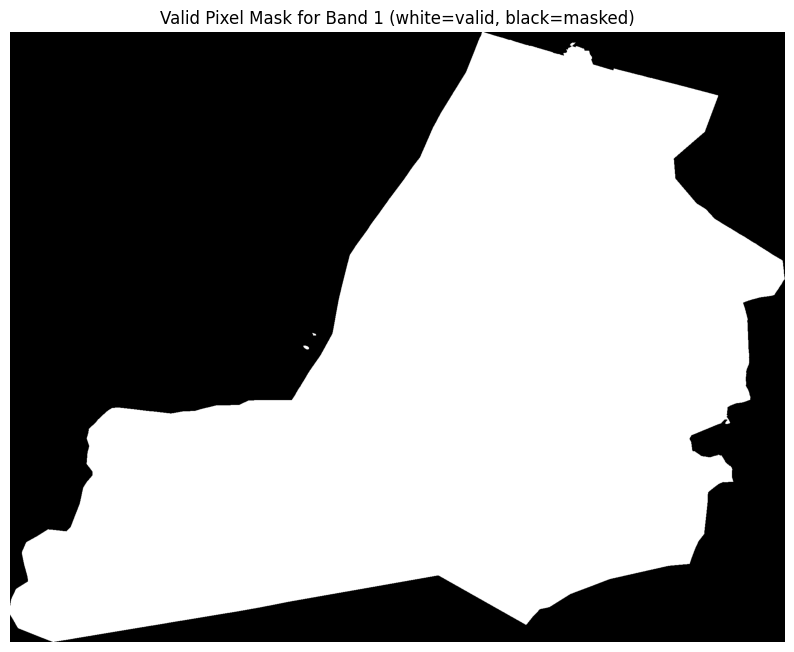

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Define the TIFF file path (you can change this to any file from your set)
tiff_path = r"/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-17.tif"

# Open the TIFF file using Rasterio
with rasterio.open(tiff_path) as src:
    # Read band 1 (assuming it is LST_C)
    band1 = src.read(1).astype(float)
    print(f"{tiff_path} has shape: {band1.shape}")

# Create a valid pixel mask: True (or 1) for valid pixels, False (or 0) where NaN
valid_mask = ~np.isnan(band1)

# Optionally, compute the percentage of valid pixels:
total_pixels = band1.size
valid_count = np.count_nonzero(valid_mask)
pct_valid = (valid_count / total_pixels) * 100
print(f"Valid Pixels: {valid_count} of {total_pixels} ({pct_valid:.2f}%)")

# Visualize the mask using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(valid_mask, cmap='gray')
plt.title("Valid Pixel Mask for Band 1 (white=valid, black=masked)")
plt.axis("off")
plt.show()


Extracted 404 valid patches from NYC_16day_2018_2018-01-01.tif.


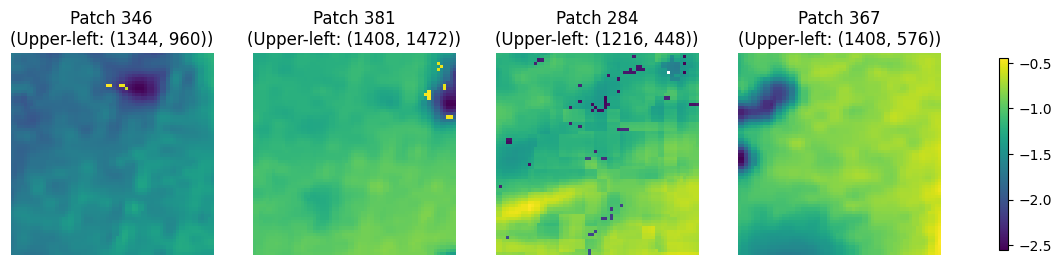

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import random

def extract_valid_patches(image_path, patch_size=64, valid_threshold=0.8):
    """
    Extract patches from a TIFF file and return only those patches
    where the fraction of valid (non-NaN) pixels in Band 1 meets or exceeds valid_threshold.

    Parameters:
        image_path (str): Path to the TIFF file.
        patch_size (int): Size (in pixels) of the square patch.
        valid_threshold (float): Minimum fraction of valid pixels required (0 to 1).

    Returns:
        patches (list): List of patches as numpy arrays with shape (bands, patch_size, patch_size).
        coords (list): Upper left (row, col) pixel coordinates of each extracted patch.
    """
    patches = []
    coords = []

    with rasterio.open(image_path) as src:
        # Read entire image (all bands)
        img = src.read()  # shape: (bands, height, width)
        height, width = src.height, src.width

        # Create a validity mask from the first band (e.g., LST_C)
        valid_mask = ~np.isnan(img[0])

        # Slide a window over the image
        for row in range(0, height - patch_size + 1, patch_size):
            for col in range(0, width - patch_size + 1, patch_size):
                window = Window(col_off=col, row_off=row, width=patch_size, height=patch_size)
                patch = src.read(window=window)  # shape: (bands, patch_size, patch_size)
                patch_mask = valid_mask[row:row+patch_size, col:col+patch_size]
                valid_fraction = np.count_nonzero(patch_mask) / patch_mask.size
                if valid_fraction >= valid_threshold:
                    patches.append(patch)
                    coords.append((row, col))

    return patches, coords

# Specify the composite file from which to extract patches.
image_path = r"/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-01.tif"
patch_size = 64
valid_threshold = 0.8

# Extract valid patches
patches, patch_coords = extract_valid_patches(image_path, patch_size, valid_threshold)
print(f"Extracted {len(patches)} valid patches from {os.path.basename(image_path)}.")

# Visualize a few patches (sample 4 patches, or fewer if not enough)
num_to_show = min(4, len(patches))
sample_indices = random.sample(range(len(patches)), num_to_show)
sample_patches = [patches[i] for i in sample_indices]

fig, axes = plt.subplots(1, num_to_show, figsize=(15,5))
for i, ax in enumerate(axes):
    # We assume Band 1 is LST_C. Display that band.
    patch_band1 = sample_patches[i][0]  # first band in the patch
    im = ax.imshow(patch_band1, cmap='viridis')
    ax.set_title(f"Patch {sample_indices[i]}\n(Upper-left: {patch_coords[sample_indices[i]]})")
    ax.axis("off")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window

def extract_valid_patches(image_path, patch_size=64, valid_threshold=0.8):
    """
    Extract patches from the TIFF file and return only those patches
    where the fraction of valid (non-NaN) pixels (in band 1) meets or exceeds valid_threshold.

    Returns:
        patches (list): List of patches (as numpy arrays with shape (bands, patch_size, patch_size)).
        coords (list): Upper-left pixel coordinates (row, col) for each patch.
    """
    patches = []
    coords = []

    with rasterio.open(image_path) as src:
        # Read the entire image (all bands)
        img = src.read()  # shape: (bands, height, width)
        height, width = src.height, src.width

        # Use the first band (LST_C) to create a validity mask (assume invalid=NaN)
        valid_mask = ~np.isnan(img[0])

        # Slide a window over the image
        for row in range(0, height - patch_size + 1, patch_size):
            for col in range(0, width - patch_size + 1, patch_size):
                window = Window(col_off=col, row_off=row, width=patch_size, height=patch_size)
                patch = src.read(window=window)  # shape: (bands, patch_size, patch_size)
                patch_mask = valid_mask[row:row+patch_size, col:col+patch_size]
                valid_fraction = np.count_nonzero(patch_mask) / patch_mask.size
                if valid_fraction >= valid_threshold:
                    patches.append(patch)
                    coords.append((row, col))

    return patches, coords

def patch_statistics(patch):
    """
    Compute statistics for each band in the patch.

    Returns:
        stats (dict): Dictionary with keys 'band_1', 'band_2', etc.
                      Each sub-dictionary contains min, max, mean, median, std, and valid_ratio.
    """
    stats = {}
    bands, height, width = patch.shape
    for b in range(bands):
        band = patch[b]
        valid_pixels = band[np.isfinite(band)]
        if valid_pixels.size > 0:
            stats[f'band_{b+1}'] = {
                'min': np.min(valid_pixels),
                'max': np.max(valid_pixels),
                'mean': np.mean(valid_pixels),
                'median': np.median(valid_pixels),
                'std': np.std(valid_pixels),
                'valid_ratio': valid_pixels.size / band.size
            }
        else:
            stats[f'band_{b+1}'] = None
    return stats

# -------------------------------
# Parameters and File Path Setup
# -------------------------------
# Specify the path to one of your composite TIFF files (update accordingly)
image_path = r"/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-01.tif"
patch_size = 64
valid_threshold = 0.8  # Only use patches with at least 80% valid (non-NaN) pixels

# Extract valid patches
patches, patch_coords = extract_valid_patches(image_path, patch_size, valid_threshold)
print(f"Extracted {len(patches)} valid patches from {os.path.basename(image_path)}.")

# -------------------------------
# Check Each Patch for Irregularities
# -------------------------------
# Define thresholds for LST_C (Band 1) that you consider unrealistic for NYC.
# For example, values less than -30 °C or greater than 40 °C might be flagged as abnormal.
LST_min_threshold = -30  # °C
LST_max_threshold = 40   # °C

irregular_patch_indices = []

for idx, patch in enumerate(patches):
    stats = patch_statistics(patch)
    # For LST_C, which is band 1
    lst_stats = stats.get('band_1')
    if lst_stats:
        if (lst_stats['min'] < LST_min_threshold) or (lst_stats['max'] > LST_max_threshold):
            irregular_patch_indices.append(idx)
            print(f"Patch {idx} at {patch_coords[idx]} is irregular: min = {lst_stats['min']:.2f}°C, max = {lst_stats['max']:.2f}°C")

print("Total irregular patches:", len(irregular_patch_indices))

# Optionally, if you want to create a report for all patches:
all_patch_stats = []
for idx, patch in enumerate(patches):
    stats = patch_statistics(patch)
    lst_stats = stats.get('band_1')
    all_patch_stats.append({
        'patch_index': idx,
        'row': patch_coords[idx][0],
        'col': patch_coords[idx][1],
        'LST_min': lst_stats['min'] if lst_stats else None,
        'LST_max': lst_stats['max'] if lst_stats else None,
        'LST_mean': lst_stats['mean'] if lst_stats else None,
        'valid_ratio': lst_stats['valid_ratio'] if lst_stats else 0
    })

import pandas as pd
df_stats = pd.DataFrame(all_patch_stats)
print(df_stats)

# You could then save this DataFrame to CSV to review it:
df_stats.to_csv(r"/content/drive/My Drive/YourDriveFolder/patch_stats.csv", index=False)
print("Patch statistics written to CSV.")


Extracted 404 valid patches from NYC_16day_2018_2018-01-01.tif.
Total irregular patches: 0
     patch_index   row   col    LST_min   LST_max  LST_mean  valid_ratio
0              0    64  1216 -13.990633 -3.514402 -6.803603     0.841797
1              1    64  1280 -14.687909 -3.538328 -7.580639     1.000000
2              2    64  1344 -14.708418 -4.902118 -9.488369     1.000000
3              3    64  1408 -14.212805 -4.051031 -9.874527     1.000000
4              4    64  1472 -14.212805 -3.459714 -8.581648     1.000000
..           ...   ...   ...        ...       ...       ...          ...
399          399  1536    64  -5.245629  2.966164 -1.469990     0.999756
400          400  1536   128  -6.238564  0.057429 -2.259700     1.000000
401          401  1536   192  -2.678696 -1.853244 -2.123686     1.000000
402          402  1536   256  -2.371074 -1.654999 -2.009107     1.000000
403          403  1536   320  -2.102760 -1.320033 -1.645095     0.917236

[404 rows x 7 columns]
Patch sta

In [ ]:
import os
import rasterio
import numpy as np

# Define the TIFF path for the composite for 2018-01-01.
tiff_file = r"/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-01.tif"

# Open the TIFF file with Rasterio.
with rasterio.open(tiff_file) as src:
    print(f"{tiff_file} has {src.count} bands and shape: {src.width}x{src.height}")

    # Read the first band, which should be LST_C according to your composite order.
    lst_band = src.read(1).astype(float)  # LST_C band
    # Read the other bands if needed:
    ndvi_band = src.read(2).astype(float)
    ndbi_band = src.read(3).astype(float)
    mndwi_band = src.read(4).astype(float)

    # Compute statistics for LST_C, excluding invalid (NaN) pixels.
    lst_valid = lst_band[np.isfinite(lst_band)]
    if lst_valid.size > 0:
        lst_min = np.min(lst_valid)
        lst_max = np.max(lst_valid)
        print(f"LST_C: min = {lst_min:.2f}, max = {lst_max:.2f}")
    else:
        print("No valid LST_C pixels found.")

    # You can similarly compute stats for other indices:
    ndvi_valid = ndvi_band[np.isfinite(ndvi_band)]
    ndbi_valid = ndbi_band[np.isfinite(ndbi_band)]
    mndwi_valid = mndwi_band[np.isfinite(mndwi_band)]

    print(f"NDVI: min = {np.min(ndvi_valid):.3f}, max = {np.max(ndvi_valid):.3f}")
    print(f"NDBI: min = {np.min(ndbi_valid):.3f}, max = {np.max(ndbi_valid):.3f}")
    print(f"MNDWI: min = {np.min(mndwi_valid):.3f}, max = {np.max(mndwi_valid):.3f}")

/content/drive/My Drive/YourDriveFolder/NYC_16day_2018_2018-01-01.tif has 4 bands and shape: 2076x1634
LST_C: min = -19.38, max = 7.67
NDVI: min = -0.943, max = 0.985
NDBI: min = -0.660, max = 0.935
MNDWI: min = -1.000, max = 0.684


In [ ]:
import os
import shutil
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.windows import transform as window_transform

def extract_valid_patches(
    image_path: str,
    patch_size: int = 64,
    stride: int = 96,
    valid_threshold: float = 0.9,
    output_dir: str = "/tmp/PatchedOutput"
):
    """
    Slide a window over the TIFF and write out only those patches
    where band 1 has ≥ valid_threshold fraction of non-NaN pixels.

    Parameters:
        image_path     Path to the TIFF file.
        patch_size     Size of each square patch.
        stride         Step (in pixels) between adjacent patches.
        valid_threshold  Fraction (0–1) of valid pixels required in band 1.
        output_dir     Local directory to write patches into.
    """
    with rasterio.open(image_path) as src:
        profile = src.profile.copy()
        H, W = src.height, src.width
        img = src.read()               # (bands, H, W)
        valid_mask = ~np.isnan(img[0]) # True where band 1 is not NaN
        base_transform = src.transform

    # update profile for patch size
    patch_profile = profile.copy()
    patch_profile.update({
        "height": patch_size,
        "width":  patch_size,
        # dtype, count, crs stay the same
    })

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    saved = 0

    # slide window again, now reading + writing only the good ones
    with rasterio.open(image_path) as src:
        for row in range(0, H - patch_size + 1, stride):
            for col in range(0, W - patch_size + 1, stride):
                submask = valid_mask[row:row+patch_size, col:col+patch_size]
                frac = submask.sum() / submask.size
                if frac < valid_threshold:
                    continue

                # read that patch
                win = Window(col, row, patch_size, patch_size)
                patch = src.read(window=win)  # (bands, patch_size, patch_size)

                # compute its geotransform
                tr = window_transform(win, base_transform)
                patch_profile["transform"] = tr

                # write it out
                out_name = f"patch_{base_name}_r{row}_c{col}_i{saved}.tif"
                out_path = os.path.join(output_dir, out_name)
                with rasterio.open(out_path, "w", **patch_profile) as dst:
                    dst.write(patch)

                saved += 1

    print(f" → {saved} patches saved for {base_name}")
    return saved

# -----------------------------
# PARAMETERS
# -----------------------------
# Your Drive-mounted paths
INPUT_DIR   = "/content/drive/My Drive/YourDriveFolder"
DRIVE_OUT   = "/content/drive/My Drive/PatchedOutput"

# Local staging (fast, robust)
TMP_OUT     = "/tmp/PatchedOutput"

PATCH_SIZE      = 64    # pixels
STRIDE          = 96    # pixels
VALID_THRESHOLD = 0.9   # 90% valid pixels in band 1

# -----------------------------
# PREPARE LOCAL STAGING
# -----------------------------
if os.path.exists(TMP_OUT):
    shutil.rmtree(TMP_OUT)
os.makedirs(TMP_OUT, exist_ok=True)

# -----------------------------
# PROCESS ALL TIFFs
# -----------------------------
tiffs = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(".tif")]
print("Found", len(tiffs), "TIFFs, extracting patches into", TMP_OUT)

total = 0
for tif in tiffs:
    path = os.path.join(INPUT_DIR, tif)
    total += extract_valid_patches(
        path, PATCH_SIZE, STRIDE, VALID_THRESHOLD, TMP_OUT
    )

print(f"\nDone! {total} patches in total.")

# -----------------------------
# COPY BACK TO DRIVE
# -----------------------------
# (clear any old output, then copy in one shot)
if os.path.exists(DRIVE_OUT):
    shutil.rmtree(DRIVE_OUT)
shutil.copytree(TMP_OUT, DRIVE_OUT)
print("All patches copied to Drive at", DRIVE_OUT)


Found 109 TIFFs, extracting patches into /tmp/PatchedOutput
 → 174 patches saved for NYC_16day_2018_2018-01-17
 → 172 patches saved for NYC_16day_2018_2018-01-01
 → 166 patches saved for NYC_16day_2018_2018-03-06
 → 174 patches saved for NYC_16day_2018_2018-04-07
 → 174 patches saved for NYC_16day_2018_2018-03-22
 → 174 patches saved for NYC_16day_2018_2018-04-23
 → 174 patches saved for NYC_16day_2018_2018-06-10
 → 174 patches saved for NYC_16day_2018_2018-05-25
 → 174 patches saved for NYC_16day_2018_2018-05-09
 → 174 patches saved for NYC_16day_2018_2018-07-12
 → 174 patches saved for NYC_16day_2018_2018-06-26
 → 174 patches saved for NYC_16day_2018_2018-07-28
 → 174 patches saved for NYC_16day_2018_2018-08-13
 → 174 patches saved for NYC_16day_2018_2018-08-29
 → 174 patches saved for NYC_16day_2018_2018-09-14
 → 174 patches saved for NYC_16day_2018_2018-10-16
 → 174 patches saved for NYC_16day_2018_2018-11-17
 → 174 patches saved for NYC_16day_2018_2018-09-30
 → 174 patches saved f

In [ ]:
import os
from collections import Counter
import pandas as pd

# 1. Point to your input TIFF folder & your patched‑output folder:
INPUT_DIR  = "/content/drive/My Drive/YourDriveFolder"
OUTPUT_DIR = "/content/drive/My Drive/PatchedOutput"

# 2. List all your original TIFFs:
tiffs = sorted([f for f in os.listdir(INPUT_DIR) if f.lower().endswith(".tif")])
print(f"Found {len(tiffs)} originals.")

# 3. Now list all the patch files:
patches = [f for f in os.listdir(OUTPUT_DIR) if f.lower().endswith(".tif")]

# 4. Group by original basename:
#    our naming is patch_<basename>_rROW_cCOL_iIDX.tif
base_counts = Counter(
    p.split("patch_")[1].rsplit("_r",1)[0]
    for p in patches
)

# 5. Build a DataFrame for easy viewing:
df = pd.DataFrame({
    "original_tif":   tiffs,
    "patch_count":    [base_counts.get(os.path.splitext(t)[0], 0) for t in tiffs]
})
df["had_patches"] = df["patch_count"] > 0

# 6. Show summary:
print("\nPer‑file patch counts:")
display(df)

print(f"\nTotal patches: {len(patches)}")
print(f"Files with zero patches: {df['had_patches'].value_counts().get(False, 0)}")


Found 109 originals.

Per‑file patch counts:


,original_tif,patch_count,had_patches
0,NYC_16day_2018_2018-01-01.tif,172,True
1,NYC_16day_2018_2018-01-17.tif,174,True
2,NYC_16day_2018_2018-03-06.tif,166,True
3,NYC_16day_2018_2018-03-22.tif,174,True
4,NYC_16day_2018_2018-04-07.tif,174,True
...,...,...,...
104,NYC_16day_2022_2022-10-16.tif,174,True
105,NYC_16day_2022_2022-11-01.tif,174,True
106,NYC_16day_2022_2022-11-17.tif,174,True
107,NYC_16day_2022_2022-12-03.tif,173,True



Total patches: 18813
Files with zero patches: 0


In [ ]:
import os
import re
import pandas as pd

# ─────────────────────────────────────────────────────────────
# 1. Point at your two directories:
# ─────────────────────────────────────────────────────────────
PATCH_DIR = "/content/drive/My Drive/PatchedOutput"                    # where patch_*.tif live
METEO_PATH = "/content/drive/My Drive/PatchedOutput/meteorological_cleaned.csv"
#            ^^^^^^^ change this to wherever you saved your cleaned CSV

# ─────────────────────────────────────────────────────────────
# 2. Load the cleaned meteorological table
# ─────────────────────────────────────────────────────────────
met = pd.read_csv(METEO_PATH, parse_dates=['date'])
# create a basename column for joining (must match your original TIFF-stem)
met['basename'] = met['composite_filename'].str.replace(r"\.tif$", "", regex=True)
# (if your CSV doesn’t already have a column named 'composite_filename',
#  create it from your date logic: e.g. "NYC_16day_2018_2018-01-01")

met = met.set_index('basename')

# ─────────────────────────────────────────────────────────────
# 3. Walk through each patch, parse its origin, and look up meteo
# ─────────────────────────────────────────────────────────────
records = []
for f in os.listdir(PATCH_DIR):
    if not f.startswith("patch_") or not f.endswith(".tif"):
        continue
    # filename format: patch_<basename>_r<row>_c<col>_i<idx>.tif
    m = re.match(r"patch_(.+?)_r(\d+)_c(\d+)_i\d+\.tif", f)
    if not m:
        continue
    basename, row, col = m.group(1), int(m.group(2)), int(m.group(3))
    if basename not in met.index:
        print(f"⚠️ no meteo record for {basename}")
        continue
    row_data = met.loc[basename]
    rec = {
        "patch_file": f,
        "basename": basename,
        "row": row,
        "col": col,
        "date":    row_data['date'],
        "air_temp_C":            row_data['air_temp_C'],
        "dew_point_C":           row_data['dew_point_C'],
        "relative_humidity_percent": row_data['relative_humidity_percent'],
        "wind_speed_m_s":        row_data['wind_speed_m_s'],
        "precipitation_in":      row_data['precipitation_in'],
    }
    records.append(rec)

out_df = pd.DataFrame(records)
out_csv = os.path.join(PATCH_DIR, "patch_metadata.csv")
out_df.to_csv(out_csv, index=False)
print(f"✔️ Wrote {len(out_df)} rows to {out_csv}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/PatchedOutput'

In [ ]:
import os

In [ ]:
import os, glob

BASE = '/content/drive/MyDrive/EarthEngine'
tifs = glob.glob(os.path.join(BASE, '*.tif'))
print("Found these .tif files:")
for f in sorted(tifs):
    print("  –", os.path.basename(f))


Found these .tif files:
  – NAIP_NYC_2022-0000000000-0000000000.tif
  – NAIP_NYC_2022-0000000000-0000032768.tif
  – NAIP_NYC_2022-0000032768-0000000000.tif
  – NAIP_NYC_2022-0000032768-0000032768.tif
  – NYC_mosaic.tif
  – nyc_buildings_mask.shp.tif
  – nyc_buildings_mask.tif
  – nyc_label_mask.tif
  – nyc_roads_mask.tif
  – nyc_soil_mask.tif
  – nyc_vegetation_mask.tif
  – nyc_water_mask.shp.tif
  – nyc_water_mask_osm.tif


In [ ]:
import os
import numpy as np
import rasterio

# 1) Base paths
BASE = '/content/drive/MyDrive/EarthEngine'
MOSAIC = os.path.join(BASE, 'NYC_mosaic.tif')
OUT    = os.path.join(BASE, 'nyc_label_mask.tif')

# 2) Point to your existing masks
paths = {
    1: os.path.join(BASE, 'nyc_water_mask_osm.tif'),
    2: os.path.join(BASE, 'nyc_buildings_mask.tif'),
    3: os.path.join(BASE, 'nyc_vegetation_mask.tif'),
    4: os.path.join(BASE, 'nyc_roads_mask.tif'),
    5: os.path.join(BASE, 'nyc_soil_mask.tif'),
}

# 3) Open the mosaic to get profile & dimensions
with rasterio.open(MOSAIC) as src:
    profile = src.profile.copy()
    profile.update(
        count=1,
        dtype='uint8',
        compress='lzw',
        tiled=True,
        blockxsize=512,
        blockysize=512
    )
    H, W = src.height, src.width

# 4) Load each binary mask into memory (they’re small, ~30 MB each)
masks = {}
for cls, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Mask for class {cls} not found at {p}")
    masks[cls] = rasterio.open(p).read(1)

# 5) Build the label array (0 = unknown by default)
labels = np.zeros((H, W), dtype='uint8')
for cls, mask in masks.items():
    labels[mask == 1] = cls

# 6) Write out the combined label raster
with rasterio.open(OUT, 'w', **profile) as dst:
    dst.write(labels, 1)

print("✅ Saved 6‑class label mask to:", OUT)


✅ Saved 6‑class label mask to: /content/drive/MyDrive/EarthEngine/nyc_label_mask.tif


In [ ]:
import numpy as np, rasterio
with rasterio.open(OUT) as src:
    data = src.read(1)
for cls in range(6):
    pct = (data==cls).mean()*100
    print(f"class {cls}: {pct:.1f}%")


class 0: 11.4%
class 1: 1.6%
class 2: 4.1%
class 3: 5.8%
class 4: 0.6%
class 5: 76.5%


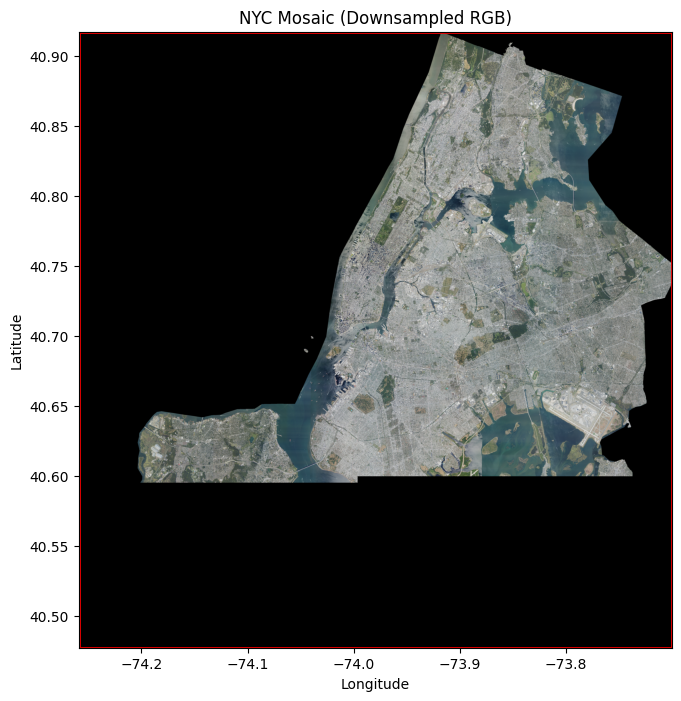

In [ ]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd

# Path to your mosaic
mosaic_fp = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'

# 1. Open and downsample for display (10× reduction)
with rasterio.open(mosaic_fp) as src:
    # Read RGB bands with resampling
    data = src.read(
        [1,2,3],
        out_shape=(
            3,
            int(src.height // 10),
            int(src.width  // 10)
        ),
        resampling=Resampling.bilinear
    )
    # Geographic extent for imshow
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# 2. Prepare RGB image
img = data.transpose(1,2,0) / 255.0  # shape (H, W, 3), normalized

# 3. Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img, extent=extent)
ax.set_title('NYC Mosaic (Downsampled RGB)')
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')

# 4. Overlay mosaic bounds as a red rectangle
rect = box(*bounds)
gpd.GeoSeries([rect], crs="EPSG:4326").boundary.plot(ax=ax, edgecolor='red', linewidth=2)

plt.show()


In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
# %% [markdown]
# ### Fetch & Rasterize OSM Directly for NYC (Vector → 1 m Segmentation)
# - OSM is vector data (no fixed “resolution”)
# - You rasterize it to your grid (here, 1 m pixels matching your mosaic)
# - We’ll pull from OSM via Overpass (using OSMnx’s geometries module)

# %% [code]
import os
import rasterio
import numpy as np
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import box
import osmnx as ox

# 1) Paths
BASE    = '/content/drive/MyDrive/EarthEngine'  # adjust if needed
MOSAIC  = os.path.join(BASE, 'NYC_mosaic.tif')
OUT_OSM = os.path.join(BASE, 'nyc_osm_segmentation.tif')

# 2) Read mosaic metadata for transform & size
with rasterio.open(MOSAIC) as src:
    crs       = src.crs
    transform = src.transform
    H, W      = src.height, src.width
    profile   = src.profile.copy()
profile.update(count=1, dtype='uint8', compress='lzw', tiled=True,
               blockxsize=512, blockysize=512)

# 3) Build bounding box of mosaic as polygon
with rasterio.open(MOSAIC) as src:
    b = src.bounds
bbox_poly = box(b.left, b.bottom, b.right, b.top)

# 4) Tags of interest for 6 classes
tags = {
    'building': True,
    'water':    True,
    'waterway': True,
    'highway':  True,  # roads
    'natural':  ['wood','grass','scrub','heath','wetland'],
    'landuse':  ['residential','commercial','industrial',
                 'brownfield','construction','park','meadow','orchard']
}

# 5) Fetch OSM geometries via Overpass for the bbox
#    Use the geometries module directly:
gdf = ox.geometries.geometries_from_bbox(
    north=b.top, south=b.bottom, east=b.right, west=b.left,
    tags=tags).to_crs(crs)

# 6) Split into semantic subsets
water_gdf    = gdf[gdf['water'].notnull() | gdf['waterway'].notnull()]
bld_gdf      = gdf[gdf['building'].notnull()]
road_gdf     = gdf[gdf['highway'].notnull()]
veg_gdf      = gdf[gdf['natural'].notnull() | gdf['landuse'].isin(['park','meadow','orchard'])]
soil_gdf     = gdf[gdf['landuse'].isin(['industrial','brownfield','construction'])]

# 7) Rasterize helper
def make_mask(sub_gdf):
    if sub_gdf.empty:
        return np.zeros((H,W), dtype='uint8')
    shapes = ((geom,1) for geom in sub_gdf.geometry if geom is not None)
    return rasterize(shapes, out_shape=(H,W), transform=transform,
                     fill=0, dtype='uint8')

# 8) Create masks
mask_water = make_mask(water_gdf)
mask_build = make_mask(bld_gdf)
mask_road  = make_mask(road_gdf)
mask_veg   = make_mask(veg_gdf)
mask_soil  = make_mask(soil_gdf)

# 9) Combine into labels 0–5
labels = np.zeros((H,W), dtype='uint8')
labels[mask_water == 1] = 1
labels[mask_build == 1] = 2
labels[mask_veg   == 1] = 3
labels[mask_road  == 1] = 4
labels[mask_soil  == 1] = 5

# 10) Save result
with rasterio.open(OUT_OSM, 'w', **profile) as dst:
    dst.write(labels, 1)

print("OSM segmentation mask saved to:", OUT_OSM)


AttributeError: module 'osmnx' has no attribute 'geometries'

=== Metadata ===
driver: GTiff
dtype: uint8
nodata: None
width: 62236
height: 49001
count: 4
crs: EPSG:4326
transform: | 0.00, 0.00,-74.26|
| 0.00,-0.00, 40.92|
| 0.00, 0.00, 1.00|

Bounds: BoundingBox(left=-74.25908923129478, bottom=40.477403982809705, right=-73.70001373107016, top=40.91758745518111)


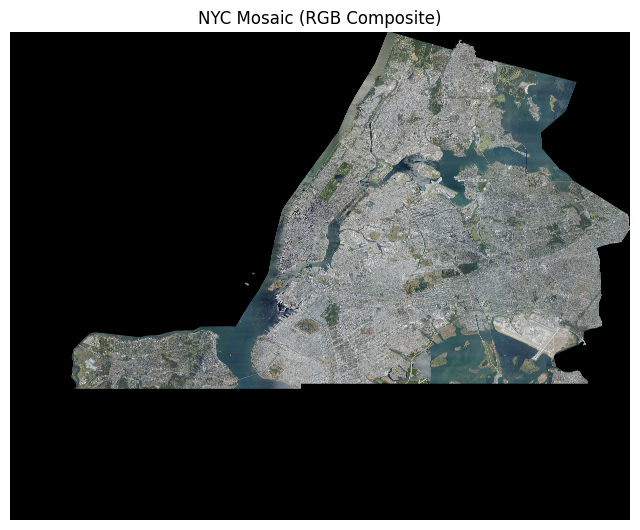

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# 2. Adjust this path if needed
mosaic_path = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'

# 3. Open and inspect metadata
with rasterio.open(mosaic_path) as src:
    print("=== Metadata ===")
    for k, v in src.meta.items():
        print(f"{k}: {v}")
    print("\nBounds:", src.bounds)

    # Read first three bands for RGB (if available)
    if src.count >= 3:
        rgb = np.dstack((src.read(1), src.read(2), src.read(3)))
    else:
        rgb = src.read(1)

# 4. Display the mosaic
plt.figure(figsize=(8, 8))
if src.count >= 3:
    plt.imshow(rgb)
    plt.title("NYC Mosaic (RGB Composite)")
else:
    plt.imshow(rgb, cmap='gray')
    plt.title("NYC Mosaic (Single Band)")
plt.axis('off')
plt.show()

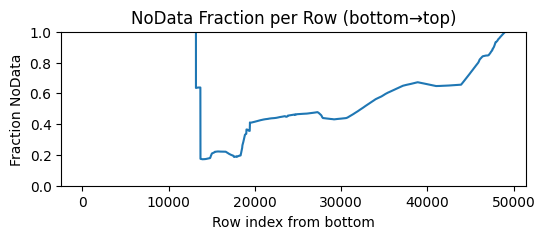

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

mosaic_path = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'

# Re-open and analyze inside the context
with rasterio.open(mosaic_path) as src:
    arr = src.read(1)
    nodata_val = src.nodata if src.nodata is not None else 0

# Compute fraction of NoData per row
frac_nodata = (arr == nodata_val).mean(axis=1)

# Plot
plt.figure(figsize=(6,2))
plt.plot(frac_nodata[::-1])  # bottom row on the right
plt.ylim(0,1)
plt.title("NoData Fraction per Row (bottom→top)")
plt.xlabel("Row index from bottom")
plt.ylabel("Fraction NoData")
plt.show()


In [ ]:
!pip install --upgrade osmnx

In [ ]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 128.1 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
from rasterio.windows import Window, from_bounds
from rasterio.features import rasterize
import fiona
import numpy as np

# paths
mosaic = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'
shp_dir = '/content/drive/MyDrive/EarthEngine/osm'
out_dir = '/content/drive/MyDrive/EarthEngine/labels_tiles'
os.makedirs(out_dir, exist_ok=True)

# open mosaic once to grab meta
src = rasterio.open(mosaic)
meta = src.meta.copy()

# pick tile size
TILE = 512

# iterate over a grid of windows
n_cols = (src.width  + TILE-1)//TILE
n_rows = (src.height + TILE-1)//TILE

for i in range(n_cols):
    for j in range(n_rows):
        win = Window(i*TILE, j*TILE, TILE, TILE).intersection(Window(0,0,src.width,src.height))
        if win.width<50 or win.height<50:
            continue  # skip tiny edge windows

        # read bands for this window (bands 1=red,2=green,3=blue,4=nir)
        data = src.read([1,2,3,4], window=win).astype('float32')
        red, green, blue, nir = data

        # compute NDVI
        ndvi = (nir - red)/(nir + red + 1e-6)

        # build an affine transform for this window
        transform = src.window_transform(win)
        shape = (int(win.height), int(win.width))

        # helper to rasterize a shapefile into this window
        def make_mask(shpfile):
            with fiona.open(shpfile, 'r') as srcv:
                geoms = [ (feat["geometry"], 1) for feat in srcv ]
            return rasterize(
                geoms, out_shape=shape, transform=transform,
                fill=0, all_touched=True, dtype='uint8'
            )

        # rasterize each class
        bld = make_mask(os.path.join(shp_dir,'buildings.shp'))
        road= make_mask(os.path.join(shp_dir,'roads.shp'))
        wat = make_mask(os.path.join(shp_dir,'water.shp'))
        veg = (ndvi > 0.3).astype('uint8')

        # combine: 0=other,1=build,2=road,3=water,4=veg
        lbl = np.zeros(shape, 'uint8')
        lbl[bld==1] = 1
        lbl[road==1]= 2
        lbl[wat==1] = 3
        lbl[veg==1] = 4

        # write out this tile
        out_meta = meta.copy()
        out_meta.update({
            'height': shape[0], 'width': shape[1],
            'transform': transform,
            'count': 1, 'dtype':'uint8', 'nodata':0
        })
        out_fp = f'{out_dir}/tile_{i}_{j}.tif'
        with rasterio.open(out_fp,'w',**out_meta) as dst:
            dst.write(lbl,1)


DriverError: Failed to open dataset (flags=68): /content/drive/MyDrive/EarthEngine/osm/buildings.shp

In [ ]:
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import rasterio
from rasterio.windows import Window
import numpy as np

# Parameters
tif_path = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'
out_path = '/content/drive/MyDrive/NYC_classified.tif'
tile_size = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained DeepLabV3
model = deeplabv3_resnet101(pretrained=True).to(device)
model.eval()

# Pre‐processing transform (as expected by the model)
preproc = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

with rasterio.open(tif_path) as src:
    profile = src.profile.copy()
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
    height, width = src.height, src.width

    # Create output file
    with rasterio.open(out_path, 'w', **profile) as dst:
        # Iterate over tiles
        for top in range(0, height, tile_size):
            for left in range(0, width, tile_size):
                window = Window(left, top, tile_size, tile_size).intersection(Window(0, 0, width, height))
                img = src.read(window=window)  # shape: (bands, h, w)

                # Convert first three bands to RGB (adjust indices if needed)
                rgb = np.stack([img[2], img[1], img[0]], axis=-1)

                # Run model
                inp = preproc(rgb).unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(inp)['out'][0]
                mask = output.argmax(0).cpu().numpy().astype(np.uint8)

                # Write the predicted mask to output
                dst.write(mask, 1, window=window)

print(f"Saved classified map to {out_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 212MB/s]


Saved classified map to /content/drive/MyDrive/NYC_classified.tif


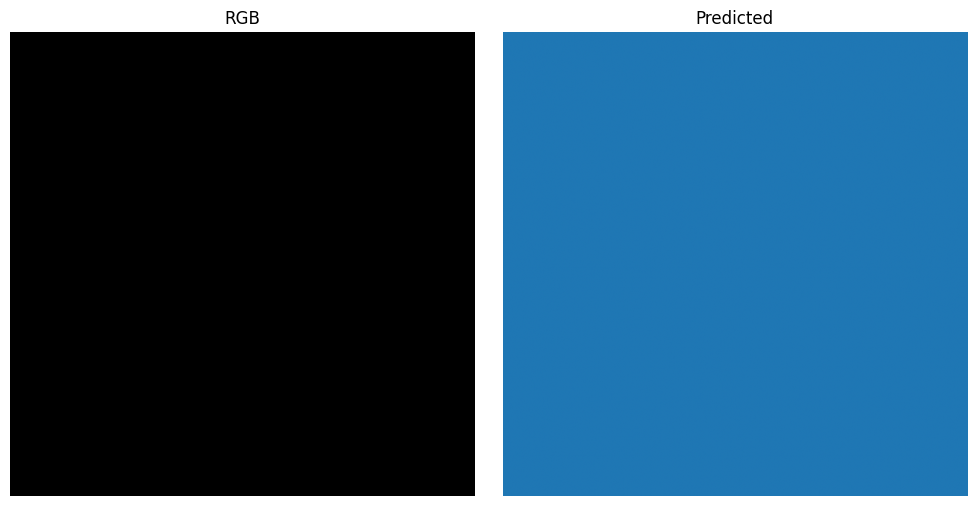

In [ ]:
import matplotlib.pyplot as plt
from rasterio.windows import Window

# pick a window
win = Window(1000,1000,512,512)
with rasterio.open('/content/drive/MyDrive/NYC_classified.tif') as psrc:
    mask = psrc.read(1, window=win)
with rasterio.open('/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif') as isrc:
    rgb  = np.stack(isrc.read([3,2,1], window=win), axis=-1)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb);  ax[0].set_title('RGB');  ax[0].axis('off')
ax[1].imshow(mask, cmap='tab10'); ax[1].set_title('Predicted'); ax[1].axis('off')
plt.tight_layout()
plt.show()

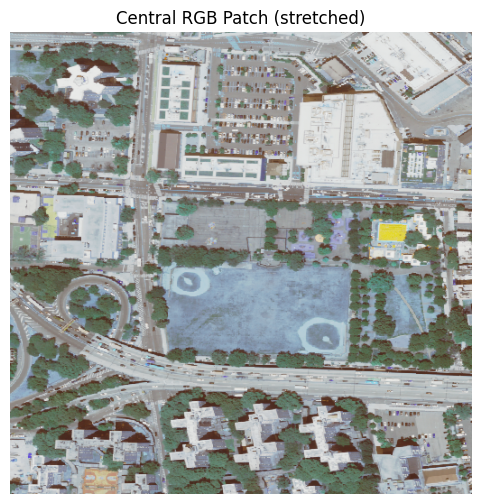

In [ ]:
import matplotlib.pyplot as plt
from rasterio.windows import Window
import rasterio
import numpy as np

# open once
with rasterio.open('/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif') as src:
    w,h = src.width, src.height
    # center window
    win = Window(w//2-256, h//2-256, 512, 512)
    rgb = src.read([3,2,1], window=win)  # shape=(3,512,512)

# OPTION A: divide by 255 for 8‑bit data
img = np.transpose(rgb, (1,2,0)) / 255.0

# OPTION B: automatic min/max stretch
# mn, mx = img.min(), img.max()
# img = (img - mn) / (mx - mn)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title('Central RGB Patch (stretched)')
plt.axis('off')
plt.show()


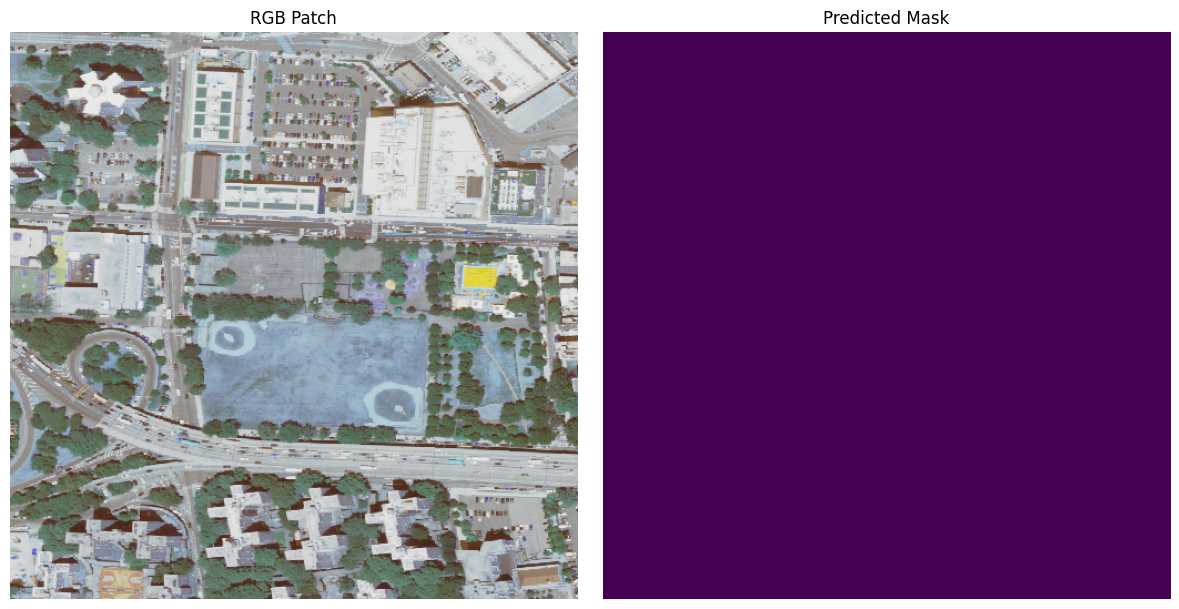

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.windows import Window

# Paths
tif_path = '/content/drive/MyDrive/EarthEngine/NYC_mosaic.tif'
pred_path = '/content/drive/MyDrive/NYC_classified.tif'

# Define a centered 512×512 window
with rasterio.open(tif_path) as src:
    w, h = src.width, src.height
window = Window(w//2 - 256, h//2 - 256, 512, 512)

# Read RGB patch
with rasterio.open(tif_path) as src:
    rgb = src.read([3, 2, 1], window=window)  # bands for R,G,B

# Read predicted mask
with rasterio.open(pred_path) as src:
    mask = src.read(1, window=window)

# Normalize RGB for display
rgb_img = np.transpose(rgb, (1, 2, 0)) / 255.0

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb_img)
axes[0].set_title('RGB Patch')
axes[0].axis('off')

axes[1].imshow(mask)
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install torch torchvision segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import torch
import segmentation_models_pytorch as smp

# 1) Define a single‑class U‑Net head (buildings vs. background)
model = smp.Unet(
    encoder_name="resnet34",        # encoder
    encoder_weights=None,           # we’ll load custom weights
    in_channels=3,                  # RGB
    classes=1,                      # building / non‑building
)

# 2) Download the INRIA‑trained weights
# (these weights segment building footprints on aerial imagery)
!wget \
  https://github.com/martenfransen/inria-aerial-building-segmentation/releases/download/v1.0/resnet34_unet_inria.pth \
  -O inria_resnet34_unet.pth

import torch, numpy as np
import segmentation_models_pytorch as smp
import rasterio
from rasterio.windows import Window

# 1) Load the pretrained INRIA model (buildings vs background)
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,    # building mask
)
state = torch.load("inria_resnet34_unet.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()

# 2) Inference on your mosaic
tif = "EarthEngine/NYC_mosaic.tif"
out = "NYC_buildings_mask.tif"

with rasterio.open(tif) as src:
    profile = src.profile.copy()
    profile.update(dtype="uint8", count=1, compress="lzw")
    tile = 512

    with rasterio.open(out, "w", **profile) as dst:
        for i in range(0, src.width, tile):
            for j in range(0, src.height, tile):
                win = Window(i, j, tile, tile).intersection(
                    Window(0, 0, src.width, src.height)
                )
                img = src.read([3,2,1], window=win)      # R,G,B
                img = np.transpose(img, (1,2,0)) / 255.0
                inp = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).float()

                with torch.no_grad():
                    pred = model(inp).squeeze().sigmoid().numpy()
                mask = (pred > 0.5).astype("uint8")
                dst.write(mask, 1, window=win)

print("Building mask saved to", out)


--2025-04-18 20:14:54--  https://github.com/martenfransen/inria-aerial-building-segmentation/releases/download/v1.0/resnet34_unet_inria.pth
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-18 20:14:54 ERROR 404: Not Found.



EOFError: 

In [ ]:
!pip install -q condacolab
import condacolab; condacolab.install()     # installs mamba + conda
!wget https://raw.githubusercontent.com/CosmiQ/solaris/main/environment-gpu.yml
!mamba env update -n base -f environment-gpu.yml
# (restart runtime)
!pip install solaris


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...
--2025-04-18 20:18:45--  https://raw.githubusercontent.com/CosmiQ/solaris/main/environment-gpu.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734 [text/plain]
Saving to: ‘environment-gpu.yml’

environment-gpu.yml 100%[===================>]     734  --.-KB/s    in 0s      

2025-04-18 20:18:45 (59.6 MB/s) - ‘environment-gpu.yml’ saved [734/734]

Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: \ | / ^C
  Using cached solaris-0.4.0-py3-none-any.whl.metadata (1.5 kB)
R

  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached segmentation_models_pytorch-0.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolv